# **Analyzing the effects of various factors on the significance/impactfulness of Earthquakes**
By: Mu Ye Liu and Edmund Chu

In [2]:
# Load required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

### **Brief insight about our analysis** 
##### **About the dataset**

The dataset we are using contains a sample 782 earthquakes of varying magnitudes recorded between Jan 1, 2002 to Jan 1, 2023. The data was provided by the USGS (United States Geological Survey), and is obtained via API requests. All earthquakes have their time, magnitude, shaking intensity, location, depth, etc, recorded. A description of all variables is listed below. Note that some entries have "NaN" for certain variables, which indicates missing/lost information from that entry.

##### **Goal and motivation of our analysis**

Many earthquakes happen every year. Not all are made equal. Some are minor and hardly felt, while others are disruptive, violent and devastating, resulting in billions of dollars in damage and social unrest. The main purpose of our analysis is to examine how important aspects of an earthquake, such as the magnitude, intensity, depth, and whether or not a tsunami was generated effect the impactfulness of an earthquake. Moreover, our goal is to also predict the potential impactfulness of a new earthquake based on given magnitude, intensity, etc parameters. This will give us an insight on how much damage will be caused by an earthquake if it were to occur in the future, allowing for further statistical exploration. This includes topics such as for example: how much the affected country's economy will be disrupted, how much funding should be allocated to recover from the earthquake disaster, model the number of casualties (injuries and deaths) that will likely result from the earthquake. 

Therefore, research question that will be further analyzed is: *Based on the magnitude, shaking intensity, depth of an earthquake, as well as whether or not a tsunami was triggered, how severe and impactful will that earthquake be?*

### **Load the Dataset**

In [3]:
# Load the data to analyze into the notebook
earthquake_data = pd.read_csv('earthquake data/earthquake_data.csv')
earthquake_data

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,"M 7.7 - 28 km SSW of Puerto El Triunfo, El Sal...",7.7,13-01-2001 17:33,0,8,NaN,0,912,us,427,0.000,0.0,mwc,60.000,13.0490,-88.660,"Puerto El Triunfo, El Salvador",NaN,NaN
778,"M 6.9 - 47 km S of Old Harbor, Alaska",6.9,10-01-2001 16:02,5,7,NaN,0,745,ak,0,0.000,0.0,mw,36.400,56.7744,-153.281,"Old Harbor, Alaska",North America,NaN
779,"M 7.1 - 16 km NE of Port-Olry, Vanuatu",7.1,09-01-2001 16:49,0,7,NaN,0,776,us,372,0.000,0.0,mwb,103.000,-14.9280,167.170,"Port-Olry, Vanuatu",NaN,Vanuatu
780,"M 6.8 - Mindanao, Philippines",6.8,01-01-2001 08:54,0,5,NaN,0,711,us,64,0.000,0.0,mwc,33.000,6.6310,126.899,"Mindanao, Philippines",NaN,NaN


### **Brief Description of Variables**

##### 1. **title:**  &nbsp;<span style="font-size: 16px;">Title or name given to the earthquake event.

##### 2. **magnitude:**  &nbsp;<span style="font-size: 16px;">The magnitude of the earthquake, measuring the energy released.

##### 3. **date_time:**  &nbsp;<span style="font-size: 16px;">Date and time of the earthquake occurrence.

##### 4. **cdi:**  &nbsp;<span style="font-size: 16px;">The maximum reported intensity for the event, based on community reports.

##### 5. **mmi:**  &nbsp;<span style="font-size: 16px;">Maximum estimated instrumental intensity (ground shaking) for the event.

##### 6. **alert:**  &nbsp;<span style="font-size: 16px;">Alert level categorized as “green”, “yellow”, “orange”, or “red.”

##### 7. **tsunami:**  &nbsp;<span style="font-size: 16px;">Binary indicator (1 = tsunami occurred, 0 = no tsunami).

##### 8. **sig:**  &nbsp;<span style="font-size: 16px;">A composite significance score indicating the overall impact of the event. A higher score indicates a more impactful, devastating earthquake

##### 9. **net:**  &nbsp;<span style="font-size: 16px;">ID of the data contributor network providing information on the event.

##### 10. **nst:**  &nbsp;<span style="font-size: 16px;">Total number of seismic stations used to determine the earthquake location.

##### 11. **dmin:**  &nbsp;<span style="font-size: 16px;">Horizontal distance from the epicenter to the nearest seismic station.

##### 12. **gap:**  &nbsp;<span style="font-size: 16px;">Largest azimuthal gap between seismic stations, measured in degrees.

##### 13. **magType:**  &nbsp;<span style="font-size: 16px;">Method or algorithm used to calculate the magnitude of the earthquake.

##### 14. **depth:**  &nbsp;<span style="font-size: 16px;">Depth at which the earthquake rupture begins, measured in kilometers.

##### 15. **latitude / longitude:**  &nbsp;<span style="font-size: 16px;">Geographic coordinates specifying the earthquake’s epicenter, recorded in degrees for both latitude and longitude. Negative Latitude indicates the southern hemisphere, negative Longitude indicates the west half of the world.

##### 16. **location:**  &nbsp;<span style="font-size: 16px;">Describes the earthquake’s location within a country.

##### 17. **continent:**  &nbsp;<span style="font-size: 16px;">Continent where the earthquake occurred.

##### 18. **country:**  &nbsp;<span style="font-size: 16px;">Country that was the most affected by the earthquake

### **Clean and filter the data to only use relevant variables**

The dataset that is used contains many variables (covariates). The goal of this analysis is to analyze and predict the impactfulness of an earthquake based on its magnitude, mmi shaking intensity, earthquake depth, and whether or not a tsunami was generated (whether or not it occurred under the ocean). Therefore, only the variables: **magnitude**, **mmi**, **tsunami**, **depth** and **sig** will be considered for the analysis, with all other variables omitted. The **sig** (or significance score) will be the response variable and simultaneously, the one we aim to predict based on given parameters.

In [4]:
# Select the columns that will be used our data analysis
earthquake_data_filtered = earthquake_data[['magnitude', 'mmi', 'tsunami', 'sig', 'depth']].round({'depth': 2})
earthquake_data_filtered

,magnitude,mmi,tsunami,sig,depth
0,7.0,7,1,768,14.00
1,6.9,4,0,735,25.00
2,7.0,3,1,755,579.00
3,7.3,5,1,833,37.00
4,6.6,2,1,670,624.46
...,...,...,...,...,...
777,7.7,8,0,912,60.00
778,6.9,7,0,745,36.40
779,7.1,7,0,776,103.00
780,6.8,5,0,711,33.00



### **Description of Variables Used in Analysis (More in depth)**

#### **1. Magnitude (magnitude)** &nbsp;<span style="font-size: 16px;"> *Covariate/Explanatory Variable*
**Definition:**  
Measures the energy released during an earthquake, represented on the Richter scale.  

**Relevance:**  
Larger magnitudes often lead to more damage and higher societal impact. This is a key predictor of risk, influencing structural damage and fatalities.

---

#### **2. Maximum Instrumental Intensity (mmi)** &nbsp;<span style="font-size: 16px;"> *Covariate/Explanatory Variable*
**Definition:**  
Represents the estimated intensity of ground shaking experienced during the earthquake.  

**Relevance:**  
Higher intensity values correspond to stronger ground motion, which is more likely to cause damage to buildings and infrastructure, making it a critical factor in risk assessment.

---

#### **3. Depth (depth)** &nbsp;<span style="font-size: 16px;"> *Covariate/Explanatory Variable*
**Definition:**  
Indicates how deep the earthquake originated below the Earth's surface, measured in kilometers.  

**Relevance:**  
Shallow earthquakes (lower depth) are often more destructive than deeper ones because the energy is released closer to the surface, intensifying its impact.

---

#### **4. Tsunami Indicator (tsunami)** &nbsp;<span style="font-size: 16px;"> *Covariate/Expanatory Variable*
**Definition:**  
A binary indicator (1 = tsunami occurred, 0 = no tsunami) specifying whether the earthquake generated a tsunami.  

**Relevance:**  
Tsunamis can cause catastrophic damage in coastal areas, amplifying the risk associated with an earthquake. Including this variable helps identify multi-hazard scenarios.

---

#### **5. Significance (sig)** &nbsp;<span style="font-size: 16px;"> *Response/Dependent variable*
**Definition:**  
A composite score capturing the overall impact of the earthquake, factoring in magnitude, MMI, and felt reports.  

**Relevance:**  
A score that is used to quantify societal impacts, which is used to evaluate and predict risk based on the covariates listed above.

---

## **Preliminary Analysis of Earthquake Data**

### **Plots**

To better understand the relationship between the response variable (sig) and the explanatory variables (magnitude, mmi, depth, and tsunami), we generated scatterplots and boxplots to conduct an exploratory data analysis (EDA).

The purpose of these visualizations is to:
- Identify trends or patterns between the explanatory variables and the response variable.
- Detect non-linear relationships that may not be captured by linear models.
- Observe variability in significance (sig) based on the predictors and explanatory variables.
- Highlight outliers and examine their potential influence on the data.

This visual inspection will also help guide further steps such as data transformations, feature engineering, or modeling techniques.

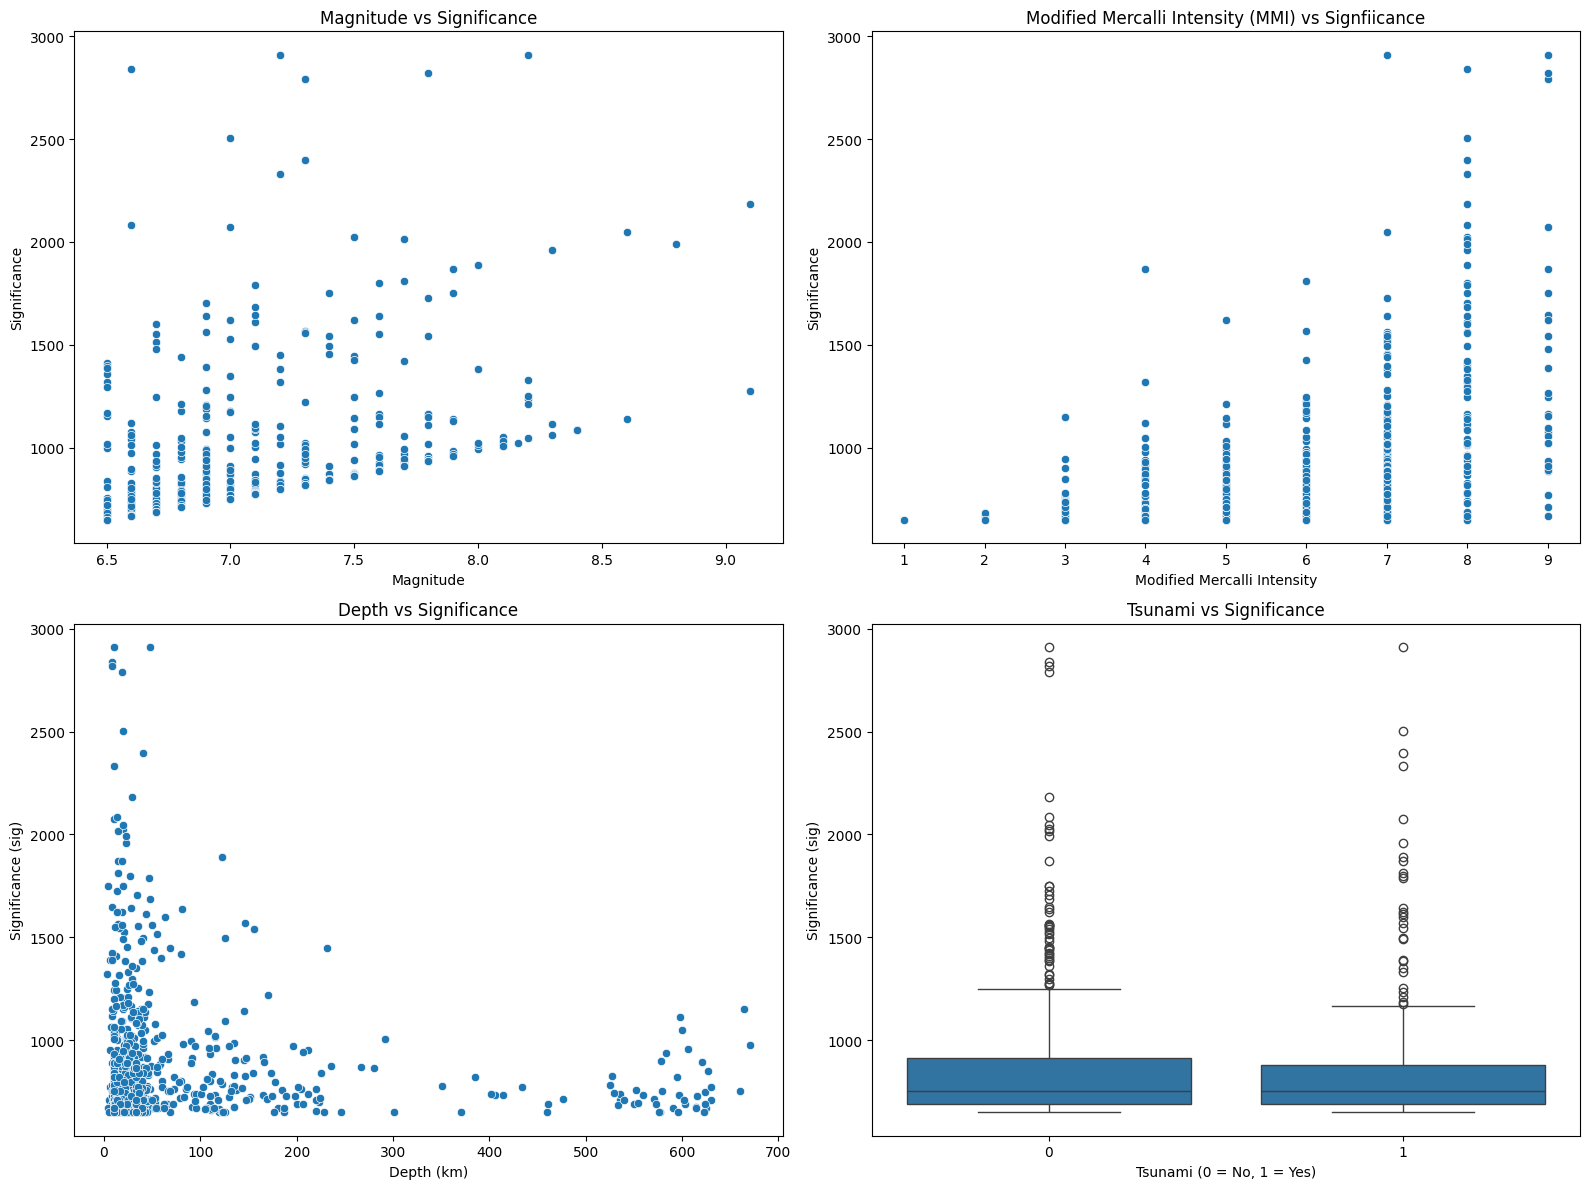

In [5]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(data = earthquake_data_filtered, x = 'magnitude', y = 'sig')
plt.title('Magnitude vs Significance')
plt.xlabel('Magnitude')
plt.ylabel('Significance')

plt.subplot(2, 2, 2)
sns.scatterplot(data = earthquake_data_filtered, x = 'mmi', y = 'sig')
plt.title('Modified Mercalli Intensity (MMI) vs Signfiicance')
plt.xlabel('Modified Mercalli Intensity')
plt.ylabel('Significance')

plt.subplot(2, 2, 3)
sns.scatterplot(data = earthquake_data_filtered, x='depth', y='sig')
plt.title('Depth vs Significance')
plt.xlabel('Depth (km)')
plt.ylabel('Significance (sig)')

plt.subplot(2, 2, 4)
sns.boxplot(data = earthquake_data_filtered, x='tsunami', y='sig')
plt.title('Tsunami vs Significance')
plt.xlabel('Tsunami (0 = No, 1 = Yes)')
plt.ylabel('Significance (sig)')

plt.tight_layout()
plt.show()



### **Preliminary Analysis of Graphs**

#### **1. Magnitude vs Significance (Top Left)**  
**Purpose:**  
Explore how earthquake magnitude affects the significance (sig) of an event.

**Observations:**  
Most earthquakes have magnitudes between 6.5 and 8.0.
No strong linear pattern is observed, but higher magnitudes tend to have slightly higher significance scores.
There is a wide spread in sig values for each magnitude, indicating that magnitude alone does not fully explain earthquake impact.

#### **2. Modified Mercalli Intensity (MMI) vs Significance (Top Right)**  
**Purpose:** Examine whether perceived shaking intensity (mmi) influences significance (sig).

**Observations:**
Higher MMI values (e.g., 7–9) generally correspond to higher significance scores, showing a positive relationship.
The discrete nature of mmi levels (integer values) results in clusters rather than a continuous trend.
Higher MMI values are less frequent but show more extreme sig values, suggesting severe shaking events tend to be more impactful.

#### **3. Depth vs Significance (Bottom Left)**  
**Purpose:**  
Investigate how earthquake depth relates to significance (sig).

**Observations:**  
Most earthquakes occur at shallower depths (0–100 km), where significance tends to be higher.
Deeper earthquakes (>300 km) generally have lower significance, with a few exceptions.
This suggests that shallow earthquakes may have a greater surface impact, contributing to higher significance scores.

#### **4. Tsunami vs Significance (Bottom Right)**  
**Purpose:**  
Assess the influence of tsunami occurrence (0 = No, 1 = Yes) on significance (sig).

**Observations:**  
The boxplots for both categories are similar, indicating tsunami occurrence may not strongly influence the sig variable. However, both categories show outliers with higher sig values, suggesting that some tsunami-related events may still have extreme impacts. Further analysis may be needed to disentangle tsunami effects from other variables like location and magnitude.

---

### **Check for Multicollinary**

In this dataset, the 2 variables: mmi (maximum shaking intensity), magnitude (earthquake magnitude) are directly related to each other as they both indicate how violent an earthquake is. Intuitively, it is plausible to believe that as magnitude of an earthquake increases, so will its shaking intensity, which means that they could be directly related/correlated with each other. So we decided to examine whether or not a problem of multicollinearity exists by computing the Variance Inflation Factor (VIF) across all continuous covariates (mmi, magnitude, depth) to determine if any of them should be removed based on the commonly used VIF threshold of being > 10. 

Mathematically, the VIF is computed by the following formula: 

$$
\frac{1}{1 - R_x^2}
$$

where $R_x^2$ is the squared correlation when treating the covariate in question as the response, while treating the remaining covariates as the explanatory variables. A $R_x^2$ close to 1 indicates that covariate in question is highly/almost perfectly correlated with the other ones, resulting in a very high VIF. The VIF of all the covariates are computed below.

In [6]:
X = earthquake_data_filtered[['mmi', 'magnitude', 'depth']]
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


    Variable        VIF
0        mmi  26.929421
1  magnitude  30.510411
2      depth   1.833201


#### Based on the VIF results:

All variables (mmi, magnitude, and depth) have VIF that is < 10, which is considered acceptable and suggests no significant multicollinearity.
These variables can all be included in the regression model without concerns about redundancy or instability of caused by correlations. 

---

### **Perform a 2-sample t-test for the tsunami categorical covariate**

Judging by the boxplot for the tsunami categorical variable above, its seems like an earthquake that generated a tsunami did not significanly cause more damage than an earthquake that did not. However, more information is needed to verify the observation. Therefore, we will perform an 2 sample independent t-test to determine whether or we should accept the above claim that tsuanami does not significantly cause more damage. We will perform this at a 5% significance level, or in other words, significance level = 0.05.

**Formula the hypothesis:** 

$\mu_0$ = mean significance score for earthquakes that did not generate tsunami. <br>
$\mu_1$ = mean significance score for earthquakes that did generate tsunami.

$H_0$: $\mu_0 = \mu_1$ <br> $H_1$: $\mu_0 \neq \mu_1$, 

**Determine the values of the sample statistics:**

We define the following variables which we will compute in the below cell: <br>

$n_0$ = number of earthquakes that did not generate tsunami <br>
$n_1$ = number of earthquakes that did generate tsunami

$s_0$ = standard error of earthquakes that did not generate tsunami <br>
$s_1$ = standard error of earthquakes that did generate tsunami

$\bar{x}_0$ = observed average significance score for earthquakes that did not generate a tsunami <br>
$\bar{x}_1$ = observed average significance score for earthquakes that generated a tsunami

In [7]:
# compute the value of n_0 and n_1
n_0 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 0].shape[0]
n_1 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 1].shape[0]
print("n_0 = " + str(n_0))
print("n_1 = " + str(n_1))

# compute the value of s_0 and s_1
s_0 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 0]['sig'].std().round(2)
s_1 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 1]['sig'].std().round(2)
print("s_0 = " + str(s_0))
print("s_1 = " + str(s_1))

# compute the value of xbar_0 and xbar_1
xbar_0 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 0]['sig'].mean().round(2)
xbar_1 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 1]['sig'].mean().round(2)
print("xbar_0 = " + str(xbar_0))
print("xbar_1 = " + str(xbar_1))

# compute the degrees of freedom
df = pow(pow(s_0, 2)/n_0 + pow(s_1, 2)/n_1, 2)/(pow((pow(s_0, 2)/n_0), 2)/(n_0 - 1) + pow((pow(s_1, 2)/n_1), 2)/(n_1 - 1))
print("df = " + str(df.round(2)))


n_0 = 478
n_1 = 304
s_0 = 325.15
s_1 = 318.64
xbar_0 = 874.09
xbar_1 = 863.85
df = 654.79


We have: 

$n_0$ = 478, $n_1$ = 304, $s_0$ = 325.15, $s_1$ = 318.64, $\mu_0$ = 874.09, $\mu_1$ = 863.85

After calculating the statistics above, we can determine the df (degrees of freedom), which is used for our null distribution (t-distribution) for the null model. The df is calculated using the following formula: 

$$
df = \frac{\left( \frac{s_0^2}{n_0} + \frac{s_1^2}{n_1} \right)^2}{\frac{\left( \frac{s_0^2}{n_0} \right)^2}{n_0 - 1} + \frac{\left( \frac{s_1^2}{n_1} \right)^2}{n_1 - 1}}
$$

After plugging the values in, we get a value of around 654.79, so our $df$ = 654. Consequently, our null distrubution would be $t_{654}$.

**Compute the test-statistic:**

The test statistic (t-score) is calculated as follows: 

$$
\text{t-score} = \frac{\bar{x}_0 - \bar{x}_1}{\sqrt{\frac{s_0^2}{n_0}+ \frac{s_1^2}{n_1}}}
$$

which is computed below: 

In [9]:
# Compute the t-score
t_score = (xbar_0 - xbar_1)/math.sqrt(pow(s_0, 2)/n_0 + pow(s_1, 2)/n_1)
print("t-score = " + str(t_score.round(2)))

p_value = 2*(1 - stats.t.cdf(abs(t_score), df))
print("p-value = " + str(p_value.round(2)))

t-score = 0.43
p-value = 0.66


We obtain a t-score = 0.43

**Compute the p-value and state the conclusion of the test**

The P-value obtained from the test is **0.66**, which is much higher than the significance level of 0.05. Therefore, we do not reject $H_0$ in favor of $H_1$ and conclude that earthquakes that generate tsunami's are not more impactful/significant than earthquakes that don't generate tsunami's. Therefore, our kNN regression to predict significance score of a new earthquake will not include the tsunami factor. 

## **Create the predictive model**

----- Do kNN regression here. Include examples.

## **Discussion and Conclusion**

----- State findings, things to consider, limitations, how things could be further improved, etc.